<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/Boxplots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорт необходимых библиотек и определение вспомогательных функций

In [1]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 44.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=0730b1d57dd50bbf366303672c74c812c6b88d23f34825e3c2d6a17dad9dffe4
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
import pymorphy2

# Создаем экземпляр морфологического анализатора pymorphy2
morph_analyzer = pymorphy2.MorphAnalyzer()

# Функция для лемматизации текста с сохранением части речи
def lemmatize_text(text):
    text = re.sub(r'[^а-яА-Я\s]', '', text)  # Удаление всех символов, кроме букв кириллицы и пробелов
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    lemmas_pos = [(morph_analyzer.parse(word)[0].normal_form, morph_analyzer.parse(word)[0].tag.POS) for word in words if word.strip()]
    return lemmas_pos

# Функция для обработки папки с текстами студентов
def process_folder(folder_path):
    unique_lemmas_by_level = {}
    for file_path in glob.glob(folder_path + "/*.txt"):
        with open(file_path, "r", encoding='utf-8') as file:
            text = file.read()
            lemmas_pos = lemmatize_text(text)
            unique_lemmas_pos = list(set(lemmas_pos))  # Удаление неуникальных лемм
            unique_lemmas_by_level[file_path] = unique_lemmas_pos
    return unique_lemmas_by_level

Обработка текстов студентов

In [3]:
# Путь к папке с работами студентов
students_path = 'Students_texts'

# Обрабатываем папки с работами студентов
student_work = {}
folders = ['A1', 'A2', 'B1', 'B2']
for folder in folders:
    folder_path = os.path.join(students_path, folder)
    student_work[folder] = process_folder(folder_path)

# Проверка результатов обработки папки A1
print(student_work['A1'])

{'Students_texts/A1/Grayson_Rosenfeld_Entry1_ST.txt': [('симпатичный', 'ADJF'), ('здравствуй', 'INTJ'), ('дом', 'NOUN'), ('к', 'PREP'), ('зандёр', 'NOUN'), ('где', 'ADVB'), ('у', 'PREP'), ('до', 'PREP'), ('любить', 'VERB'), ('восемь', 'NUMR'), ('он', 'NPRO'), ('хорошо', 'ADVB'), ('как', 'CONJ'), ('невысокий', 'ADJF'), ('какой', 'ADJF'), ('быть', 'VERB'), ('зелёный', 'ADJF'), ('я', 'NPRO'), ('интересный', 'ADJF'), ('рука', 'NOUN'), ('ханой', 'NOUN'), ('друга', 'NOUN'), ('подруга', 'NOUN'), ('двадцать', 'NUMR'), ('свидание', 'NOUN'), ('высокий', 'ADJF'), ('еда', 'NOUN'), ('в', 'PREP'), ('грейсон', 'NOUN'), ('добрый', 'ADJF'), ('вьетнам', 'NOUN'), ('год', 'NOUN'), ('россия', 'NOUN'), ('это', 'PRCL'), ('ты', 'NPRO'), ('пятый', 'ADJF'), ('сегодня', 'ADVB'), ('мой', 'ADJF'), ('живт', 'NOUN'), ('дело', 'NOUN'), ('друг', 'NOUN'), ('они', 'NPRO'), ('есть', 'INFN'), ('глаз', 'NOUN'), ('тоже', 'PRCL'), ('и', 'CONJ'), ('один', 'ADJF')], 'Students_texts/A1/Grayson_Rosenfeld_Entry3_ST.txt': [('техно

Загрузка словаря Ляшевской и создание словаря соответствий тегов частей речи

In [8]:
# Загрузка данных Ляшевской
df_lyashevskaya = pd.read_csv('freqrnc2011.csv', sep='\t')
df_lyashevskaya['Lemma'] = df_lyashevskaya['Lemma'].str.lower()

# Создание словаря соответствий тегов частей речи
pos_mapping = {
    'NOUN': 's',
    'VERB': 'v',
    'ADJF': 'a',
    'ADJS': 'a',
    'COMP': 'a',
    'INFN': 'v',
    'PRTF': 'v',
    'PRTS': 'v',
    'GRND': 'v',
    'NUMR': 'num',
    'ADVB': 'adv',
    'NPRO': 'spro',
    'PRED': 'adv',
    'PREP': 'pr',
    'CONJ': 'conj',
    'PRCL': 'part',
    'INTJ': 'intj'
}

# Функция для присвоения ранга леммам студента
def assign_ranks(lemmas_pos, df_lyashevskaya, pos_mapping):
    ranks = []
    for lemma, pos in lemmas_pos:
        mapped_pos = pos_mapping.get(pos, None)
        if mapped_pos:
            rank = df_lyashevskaya[(df_lyashevskaya['Lemma'] == lemma) & (df_lyashevskaya['PoS'] == mapped_pos)]['Freq(ipm)']
            if not rank.empty:
                ranks.append(rank.values[0])
            else:
                ranks.append(0)
        else:
            ranks.append(0)
    return ranks

Расчет MRR для каждого документа

In [9]:
# Функция для расчета MRR
def calculate_mrr(ranks):
    if len(ranks) == 0:
        return 0
    return np.mean([1.0 / rank if rank != 0 else 0 for rank in ranks])

# Функция для обработки всех документов и расчета среднего MRR по каждому уровню
def process_all_documents(student_work, df_lyashevskaya, pos_mapping):
    mrr_scores = {level: [] for level in student_work.keys()}
    for level, works in student_work.items():
        for file, lemmas_pos in works.items():
            ranks = assign_ranks(lemmas_pos, df_lyashevskaya, pos_mapping)
            mrr = calculate_mrr(ranks)
            mrr_scores[level].append(mrr)
    return mrr_scores

# Подсчет MRR для всех документов
mrr_scores = process_all_documents(student_work, df_lyashevskaya, pos_mapping)

# Проверка MRR для уровня A1
print(mrr_scores['A1'])

[0.017386440354888635, 0.004649640531473169, 0.0028401062436669284, 0.03018365724204445, 0.004530798420826505, 0.0030917768621899467, 0.007171521564141075, 0.050413912469946476, 0.0025577097027406973, 0.028410579492482015, 0.0052042072948788026, 0.010210415291792391, 0.033943226592672585, 0.013186111940117883, 0.04170993489261866, 0.004204900448919468, 0.027189110331747774, 0.013247468308981948, 0.018000810928427716, 0.020489983045279013, 0.04089502136719178, 0.0028743322994391534, 0.00178642633056665, 0.04274204217950385, 0.012413806387146077, 0.0022589510954764114, 0.11304153771083751, 0.01154330738439119, 0.003657230329221649, 0.005936125877849969, 0.009800204362407076, 0.0010003488042438175, 0.010885435964289831, 0.0016629790933241151, 0.005192836705677636, 0.04261584670256701, 0.04436183411352488, 0.013381531951197461, 0.0023918723278807934, 0.0021701738263887665, 0.01847364129896227, 0.00940982302553521, 0.037325959228882113, 0.036321419553073823, 0.07968359390505221, 0.002672867

Визуализация результатов

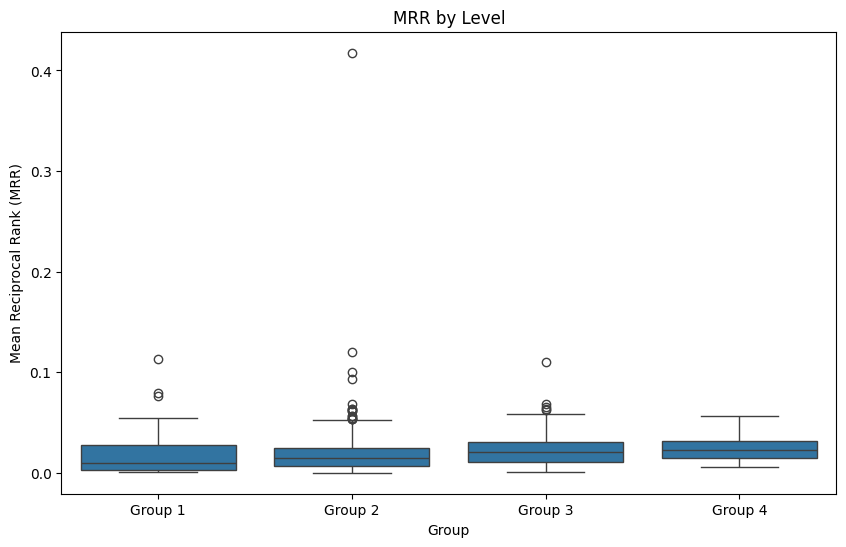

In [10]:
# Создание DataFrame для визуализации
mrr_data = []
for level, scores in mrr_scores.items():
    for score in scores:
        mrr_data.append({'Level': level, 'MRR': score})

df_mrr = pd.DataFrame(mrr_data)

# Переименование уровней для визуализации
df_mrr['Level'] = df_mrr['Level'].replace({'A1': 'Group 1', 'A2': 'Group 2', 'B1': 'Group 3', 'B2': 'Group 4'})

# Визуализация с использованием boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Level', y='MRR', data=df_mrr)
plt.title('MRR by Level')
plt.ylabel('Mean Reciprocal Rank (MRR)')
plt.xlabel('Group')
plt.show()